In [78]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [85]:
#### Data import and transform
# Transformation
transform = T.Compose([
    T.RandomResizedCrop(size=(224, 224), antialias=True),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Import the Train data
trainSet = tv.datasets.STL10(root="../Datasets/", download=True, split="train", transform=transform)

# Import the Test data
testSet = tv.datasets.STL10(root="../Datasets/", download=True, split="test", transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [86]:
print(trainSet.data.shape, testSet.data.shape)
# Data pre processing
batchSize = 32
train_loader = DataLoader(trainSet, batch_size=batchSize, shuffle=True, drop_last=True, generator=torch.Generator(device=device))
test_loader = DataLoader(testSet, batch_size=256, generator=torch.Generator(device=device))

(5000, 3, 96, 96) (8000, 3, 96, 96)


In [87]:
# check out the shape of the datasets
print("Data shapes (train/test):")
print(trainSet.data.shape)
print(testSet.data.shape)

# and the range of pixel intensity values
print("\nData value range:")
print((np.min(trainSet.data), np.max(trainSet.data)))

# the unique categories
print("\nData categories:")
print(trainSet.classes)

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [88]:
X, y = next(iter(train_loader))

# try again
print("Data shapes (train/test):")
print(X.data.shape)

# and the range of pixel intensity values
print("\nData value range:")
print((torch.min(X.data), torch.max(X.data)))

Data shapes (train/test):
torch.Size([32, 3, 224, 224])

Data value range:
(tensor(-2.1179), tensor(2.6400))


(array([30600., 33653., 13974., 19161., 11554., 22600., 50705., 32173.,
        40151., 37341., 41091., 34628., 51025., 47104., 46798., 48544.,
        53821., 57622., 47070., 73751., 70075., 72587., 49529., 75696.,
        73913., 58275., 78191., 68181., 76597., 59170., 71906., 64486.,
        67505., 65383., 70839., 70569., 52695., 58516., 63093., 65396.,
        44440., 67249., 67190., 57739., 73538., 68079., 72380., 61691.,
        63132., 62854., 61872., 60993., 66961., 65441., 55226., 77002.,
        74281., 62671., 78577., 70208., 73494., 68421., 68570., 75907.,
        58132., 60547., 51967., 48915., 46717., 46809., 37159., 33912.,
        31461., 32825., 28144., 27181., 24895., 28639., 32201., 30510.,
        31756., 20369., 26192., 29096., 30458., 25100., 25614., 23245.,
        17510., 16170., 18261., 58286., 12255., 14718., 16934., 46526.,
         4593.,  7082.,  9474., 39359.]),
 array([-2.11790395, -2.0703249 , -2.02274585, -1.9751668 , -1.92758775,
        -1.8800087 , 

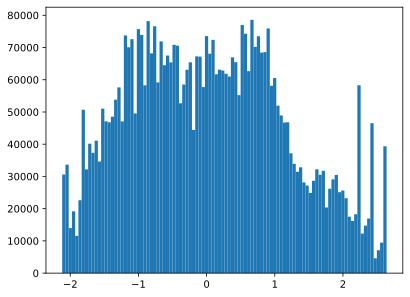

In [89]:
# histogram of the data
plt.hist(X.data.numpy().flatten(), 100)

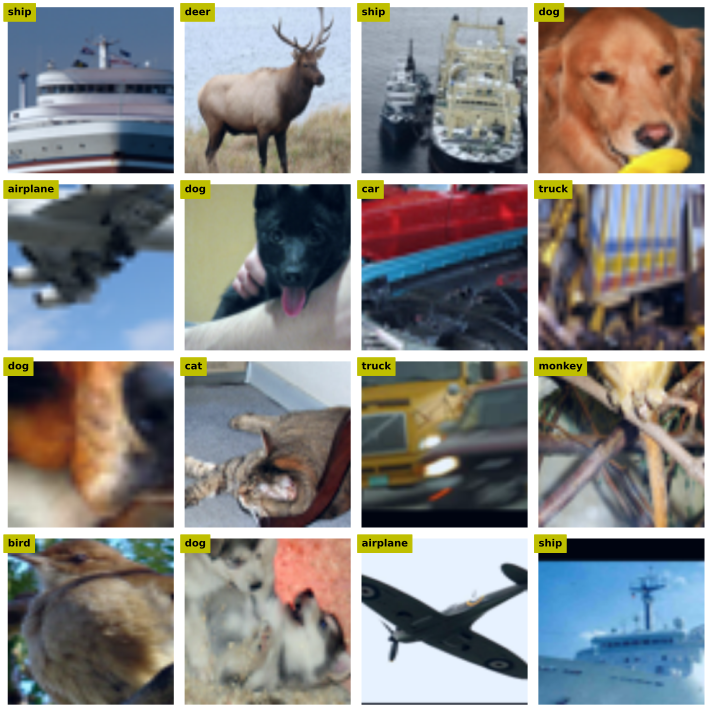

In [90]:
# inspect a few random images

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)  # undo normalization
    pic = pic / np.max(pic)

    # and its label
    label = trainSet.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        0,
        0,
        label,
        ha="left",
        va="top",
        fontweight="bold",
        color="k",
        backgroundcolor="y",
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [99]:
# Import ResNet18 model
weights = tv.models.VGG16_Weights
vgg16 = tv.models.vgg16(weights=weights)

/home/kumar/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
# Summery for number of parameters
summary(vgg16)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

In [101]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [103]:
# Freeze the layers
for p in vgg16.parameters():
    p.requires_grad = False

In [104]:
vgg16.classifier[6] = nn.Linear(4096, 10, bias=True)
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [105]:
# Loss Function and opt
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.parameters(), lr=0.0001, weight_decay=1e-3)

In [ ]:
# Train the model
numepochs = 4

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over training data batches
    vgg16.train()  # switch to train mode
    batchLoss = []
    batchAcc = []
    for X, y in train_loader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        yHat = vgg16(X)
        loss = lossfun(yHat, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100 * np.mean(batchAcc)

    #### test performance (here done in batches!)
    vgg16.eval()  # switch to test mode
    batchAcc = []
    batchLoss = []
    for X, y in test_loader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = vgg16(X)
            loss = lossfun(yHat, y)

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi] = 100 * np.mean(batchAcc)

    # print out a status update
    print(
        f"Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%"
    )

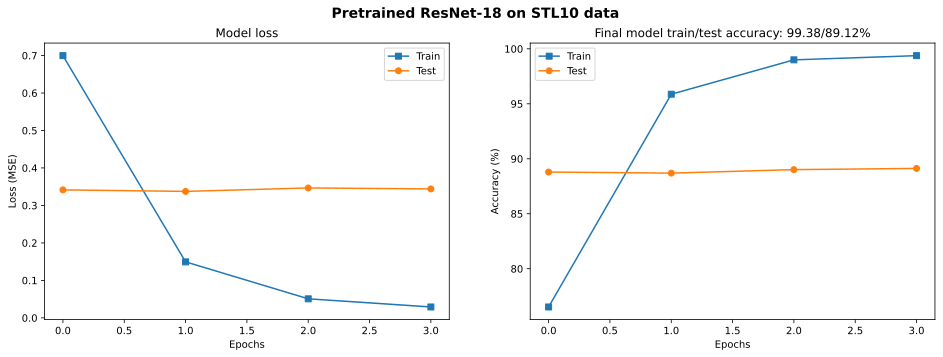

In [ ]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss.cpu(), "s-", label="Train")
ax[0].plot(testLoss.cpu(), "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model loss")
ax[0].legend()

ax[1].plot(trainAcc.cpu(), "s-", label="Train")
ax[1].plot(testAcc.cpu(), "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(
    f"Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%"
)
ax[1].legend()

plt.suptitle("Pretrained VGG-16 on STL10 data", fontweight="bold", fontsize=14)
plt.show()

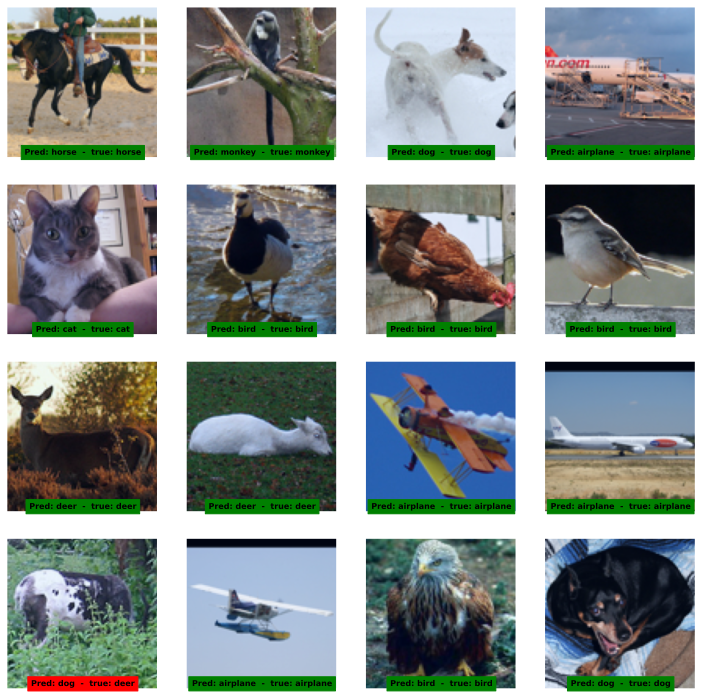

In [ ]:
# inspect a few random images

X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
vgg16.eval()
predictions = torch.argmax(vgg16(X), axis=1)


fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 96x96x3)
    pic = X.data[i].cpu().numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)  # undo normalization
    pic = pic / np.max(pic)

    # show the image
    ax.imshow(pic)

    # label and true class
    label = trainSet.classes[predictions[i]]
    truec = trainSet.classes[y[i]]
    title = f"Pred: {label}  -  true: {truec}"

    # set the title with color-coded accuracy
    titlecolor = "g" if truec == label else "r"
    ax.text(
        48,
        90,
        title,
        ha="center",
        va="top",
        fontweight="bold",
        color="k",
        backgroundcolor=titlecolor,
        fontsize=8,
    )
    ax.axis("off")

plt.tight_layout()
plt.show()